### Librerias

In [1]:
import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
import os,sys, gc
import keras


dirpath = os.getcwd().split("code")[0]+"code/"
sys.path.append(dirpath)
from pre_process import clean_LC,generate_representation
from evaluation import calculate_metrics, evaluate_metadata, evaluate_metadata_raw


folder = "../../KOI_Data/"
folder_lc = "/work/work_teamEXOPLANET/KOI_LC/"

Using TensorFlow backend.


### Datos

In [2]:
mask_transit = np.load("data/mask_transit_LC.npy")  #
mask_transit

array([ True,  True, False, ...,  True,  True,  True])

In [3]:
T = 300
X_fold_lc = np.load("data/LC_global_%dT.npy"%T)
X_fold_lc_aug = np.load("data/LC_globalA_%dT.npy"%T)
X_fold_time = np.load("data/Time_global_%dT.npy"%T)
X_fold_lc.shape

(8054, 300)

In [4]:
## NEW : set mask
X_fold_lc_tr = X_fold_lc[mask_transit]
X_fold_lc_aug_tr = X_fold_lc_aug[mask_transit]
X_fold_time_tr = X_fold_time[mask_transit]
N,T = X_fold_lc_tr.shape
N

4317

In [5]:
X_train_t = np.concatenate([X_fold_time_tr, X_fold_time_tr], axis=0)
X_train = np.concatenate([X_fold_lc_tr, X_fold_lc_aug_tr], axis=0)

X_train = np.expand_dims(X_train, axis=-1)
X_train_t = np.expand_dims(X_train_t, axis=-1)

print("X train shape: ",X_train.shape)
print("X train time shape: ",X_train_t.shape)

X train shape:  (8634, 300, 1)
X train time shape:  (8634, 300, 1)


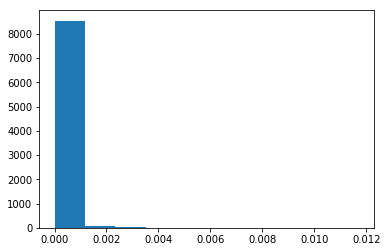

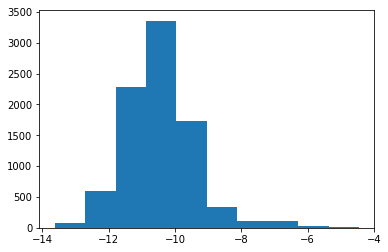

In [6]:
S_train = np.std(X_train, axis=1)
S_mu = np.mean(S_train)
S_std = np.std(S_train) 

#to train VAE-scale
Slog_mu = np.mean(np.log(S_train))
Slog_std = np.std(np.log(S_train))

plt.hist(S_train)
plt.show()
plt.hist(np.log(S_train))
plt.show()

### Keras imports

In [7]:
from keras import backend as K
from keras.models import Sequential, Model
from keras.layers import *

from IPython.display import SVG
from keras.utils.vis_utils import model_to_dot
from sklearn.metrics import mean_squared_error
def plot_n_lc(real_lc, decoded_lc, n = 10, s=None):
    for _ in range(n):
        n_sampled = np.random.randint(0, real_lc.shape[0])
        real_lc_n = np.squeeze(real_lc[n_sampled])
        decoded_lc_n = np.squeeze(decoded_lc[n_sampled])
        
        if s !=None:
            print("Real scale = %f\nPred scale = %f"%(s[0][n_sampled], s[1][n_sampled] ))
        f, (ax1, ax2, ax3) = plt.subplots(1, 3, sharey=True,figsize= (15,5))
        ax1.plot(real_lc_n, 'b.-')
        ax1.set_title("Real")
        ax2.plot(decoded_lc_n, 'b.-')
        ax2.set_title("Reconstructed")
        ax3.plot(real_lc_n-decoded_lc_n, 'b.-')
        ax3.set_title("Residuo")
        plt.show()  

        plt.figure(figsize=(15,5))
        plt.plot(real_lc_n, 'bo-', label="Real")
        plt.plot(decoded_lc_n, 'g*-', label="Reconstructed")
        plt.title("Over")
        plt.legend()
        plt.show()
        print("----------------------------------------------------------------")

In [8]:
#### IF THIS IS USED,, KL WEIGHT NEEDED TO BE LOW ######
def MSE_loss(y_true, y_pred):
    v = K.mean( K.square( y_true - y_pred ), axis=1) #on time axis..    
    return K.flatten(v)

def KL_loss(z_mean,z_log_var):
    #the mean and log-var of the latent distribution
    def KL(y_true, y_pred):
        return - 0.5 * K.sum(1 + z_log_var - K.square(z_mean) - K.exp(z_log_var), axis=-1)
    return KL

def MSLE_scale_loss(s_true, s_hat): #Mean squared logarithm error
    def MSLE_scale(y_true, y_pred):
        mse_SCALE = K.mean(K.square( K.log(s_true) - K.log(s_hat) ), axis=-1)
        return mse_SCALE / (Slog_std)**2 #divide in order to MSLE does not have scale
    return MSLE_scale

def SMSE_loss(s_lc):
    def SMSE(y_true, y_pred):
        mse_LC = MSE_loss(y_true, y_pred)
        #mse_LC = K.mean( K.square( y_true - y_pred ), axis=1) #on time axis..    
        #mse_LC = K.flatten(mse_LC)
        weights = K.square(s_lc)[:,0]
        return mse_LC / weights #both values has to be on same shape
    return SMSE

In [9]:
from autoencoder_utils import define_samp_model, get_GRU 
from autoencoder_utils import Mul_L,  Div_L, Norm_L, RevertNorm_L

BATCH_s = 64
EPOCHS = 300
latent_dim = 32
l = 0.001 #kl weight

_, T, channels = X_train.shape

In [10]:
X_train_s = X_train/S_train[:,None,:]

### AE normal (baseline)

In [30]:
x_lc = Input(shape = (T, channels) , name="LC_inp")
x_t = Input(shape = (T, 1) , name ="T_inp")

x = Concatenate(axis=-1)([x_t, x_lc]) #add time encode

f1 = Bidirectional(get_GRU(64, return_sequences=True))(x) #bidirectional
f1 = Bidirectional(get_GRU(64, return_sequences=False))(f1) #bidirectional

z = Dense(latent_dim,activation='linear')(f1)
encoder = Model([x_t, x_lc], z, name="encoder")

decoder_input = Input(shape=(latent_dim,))
decode = RepeatVector(T)(decoder_input)

decode = Concatenate(axis=-1)([x_t, decode]) #add time decode

decode = Bidirectional(get_GRU(64, return_sequences=True))(decode) #bidirectional
decode = Bidirectional(get_GRU(64, return_sequences=True))(decode) #bidirectional

decode = TimeDistributed(Dense(1, activation='linear'))(decode)
generator = Model([x_t, decoder_input], decode, name="generator")

# instantiate VAE model
out = generator([x_t, encoder([x_t, x_lc]) ])
AE_m = Model([x_t, x_lc], out)

AE_m.compile(optimizer='adam', loss=MSE_loss)

AE_m.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
T_inp (InputLayer)              (None, 300, 1)       0                                            
__________________________________________________________________________________________________
LC_inp (InputLayer)             (None, 300, 1)       0                                            
__________________________________________________________________________________________________
encoder (Model)                 (None, 16)           102672      T_inp[0][0]                      
                                                                 LC_inp[0][0]                     
__________________________________________________________________________________________________
generator (Model)               (None, 300, 1)       106497      T_inp[0][0]                      
          

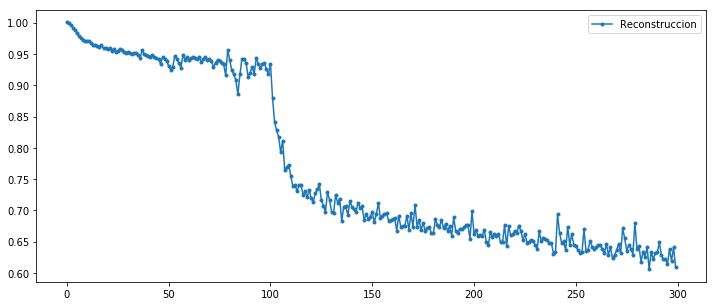

In [14]:
hist1 = AE_m.fit([X_train_t,X_train_s], X_train_s, epochs=EPOCHS, batch_size=BATCH_s)

plt.figure(figsize=(12,5))
plt.plot(hist1.history["loss"], '.-', label="Reconstruccion")
plt.legend()
plt.show()

Epoch 1/300
8634/8634 [==============================] - 22s 3ms/step - loss: 1.0004
Epoch 2/300
8634/8634 [==============================] - 18s 2ms/step - loss: 0.9990
Epoch 3/300
8634/8634 [==============================] - 18s 2ms/step - loss: 0.9958
Epoch 4/300
8634/8634 [==============================] - 18s 2ms/step - loss: 0.9925
Epoch 5/300
8634/8634 [==============================] - 18s 2ms/step - loss: 0.9882
Epoch 6/300
8634/8634 [==============================] - 18s 2ms/step - loss: 0.9831
Epoch 7/300
8634/8634 [==============================] - 18s 2ms/step - loss: 0.9784
Epoch 8/300
8634/8634 [==============================] - 18s 2ms/step - loss: 0.9762
Epoch 9/300
8634/8634 [==============================] - 18s 2ms/step - loss: 0.9767
Epoch 10/300
8634/8634 [==============================] - 18s 2ms/step - loss: 0.9766
Epoch 11/300
8634/8634 [==============================] - 18s 2ms/step - loss: 0.9735
Epoch 12/300
8634/8634 [==============================] - 18s 2

8634/8634 [==============================] - 18s 2ms/step - loss: 0.6907
Epoch 191/300
8634/8634 [==============================] - 18s 2ms/step - loss: 0.7044
Epoch 192/300
8634/8634 [==============================] - 18s 2ms/step - loss: 0.6810
Epoch 193/300
8634/8634 [==============================] - 18s 2ms/step - loss: 0.7110
Epoch 194/300
8634/8634 [==============================] - 18s 2ms/step - loss: 0.7016
Epoch 195/300
8634/8634 [==============================] - 18s 2ms/step - loss: 0.6833
Epoch 196/300
8634/8634 [==============================] - 18s 2ms/step - loss: 0.7082
Epoch 197/300
8634/8634 [==============================] - 18s 2ms/step - loss: 0.7079
Epoch 198/300
8634/8634 [==============================] - 18s 2ms/step - loss: 0.6912
Epoch 199/300
8634/8634 [==============================] - 18s 2ms/step - loss: 0.6883
Epoch 200/300
8634/8634 [==============================] - 18s 2ms/step - loss: 0.6936
Epoch 201/300
8634/8634 [==============================] 

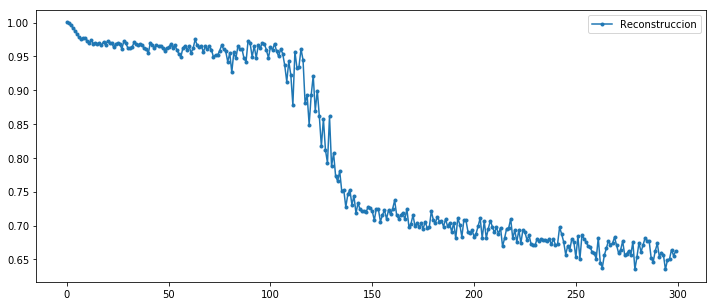

In [31]:
hist1 = AE_m.fit([X_train_t,X_train_s], X_train_s, epochs=EPOCHS, batch_size=BATCH_s)

plt.figure(figsize=(12,5))
plt.plot(hist1.history["loss"], '.-', label="Reconstruccion")
plt.legend()
plt.show() ## 16

In [32]:
AE_m.get_layer("encoder").save_weights("./models/AE_%dT_%dD_%de_E.h5"%(T,latent_dim,EPOCHS))
AE_m.get_layer("generator").save_weights("./models/AE_%dT_%dD_%de_D.h5"%(T,latent_dim,EPOCHS))

### VAE normal

In [33]:
x_lc = Input(shape = (T, channels) , name="LC_inp")
x_t = Input(shape = (T, 1) , name ="T_inp")

x = Concatenate(axis=-1)([x_t, x_lc]) #add time encode

f1 = Bidirectional(get_GRU(64, return_sequences=True))(x) #bidirectional
f1 = Bidirectional(get_GRU(64, return_sequences=False))(f1) #bidirectional

z_mean = Dense(latent_dim,activation='linear')(f1)
z_log_var = Dense(latent_dim,activation='linear')(f1)
encoder = Model([x_t, x_lc], [z_mean,z_log_var], name="encoder")
samp_model = define_samp_model(latent_dim) #model to sample

decoder_input = Input(shape=(latent_dim,))
decode = RepeatVector(T)(decoder_input)

decode = Concatenate(axis=-1)([x_t, decode]) #add time decode

decode = Bidirectional(get_GRU(64, return_sequences=True))(decode) #bidirectional
decode = Bidirectional(get_GRU(64, return_sequences=True))(decode) #bidirectional

decode = TimeDistributed(Dense(1, activation='linear'))(decode)
generator = Model([x_t, decoder_input], decode, name="generator")

# instantiate VAE model
out = generator([x_t, samp_model(encoder([x_t, x_lc])) ])
vae = Model([x_t, x_lc], out)

kl_loss = KL_loss(z_mean, z_log_var) #instantiate KL over this model
def vae_loss(y_true, y_pred):    
    return MSE_loss(y_true, y_pred) + l*kl_loss(y_true, y_pred) 

vae.compile(optimizer='adam', loss=vae_loss, metrics = [kl_loss, MSE_loss])
vae.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
T_inp (InputLayer)              (None, 300, 1)       0                                            
__________________________________________________________________________________________________
LC_inp (InputLayer)             (None, 300, 1)       0                                            
__________________________________________________________________________________________________
encoder (Model)                 [(None, 16), (None,  104736      T_inp[0][0]                      
                                                                 LC_inp[0][0]                     
__________________________________________________________________________________________________
norm_sampl (Model)              (None, 16)           0           encoder[1][0]                    
          

Epoch 1/300
8634/8634 [==============================] - 31s 4ms/step - loss: 1.0139 - KL: 0.4405 - MSE_loss: 1.0135
Epoch 2/300
8634/8634 [==============================] - 27s 3ms/step - loss: 1.0037 - KL: 0.3419 - MSE_loss: 1.0033
Epoch 3/300
8634/8634 [==============================] - 26s 3ms/step - loss: 1.0028 - KL: 0.2706 - MSE_loss: 1.0025
Epoch 4/300
8634/8634 [==============================] - 26s 3ms/step - loss: 1.0025 - KL: 0.3260 - MSE_loss: 1.0022
Epoch 5/300
8634/8634 [==============================] - 26s 3ms/step - loss: 1.0022 - KL: 0.3968 - MSE_loss: 1.0018
Epoch 6/300
8634/8634 [==============================] - 26s 3ms/step - loss: 1.0020 - KL: 0.4616 - MSE_loss: 1.0015
Epoch 7/300
8634/8634 [==============================] - 26s 3ms/step - loss: 1.0018 - KL: 0.4876 - MSE_loss: 1.0013
Epoch 8/300
8634/8634 [==============================] - 26s 3ms/step - loss: 1.0016 - KL: 0.5611 - MSE_loss: 1.0010
Epoch 9/300
8634/8634 [==============================] - 26s 3ms

8634/8634 [==============================] - 26s 3ms/step - loss: 0.7209 - KL: 12.1534 - MSE_loss: 0.7087
Epoch 139/300
8634/8634 [==============================] - 26s 3ms/step - loss: 0.7155 - KL: 12.2236 - MSE_loss: 0.7032
Epoch 140/300
8634/8634 [==============================] - 26s 3ms/step - loss: 0.7160 - KL: 12.3397 - MSE_loss: 0.7037
Epoch 141/300
8634/8634 [==============================] - 26s 3ms/step - loss: 0.7141 - KL: 12.5105 - MSE_loss: 0.7016
Epoch 142/300
8634/8634 [==============================] - 26s 3ms/step - loss: 0.7271 - KL: 12.1810 - MSE_loss: 0.7149
Epoch 143/300
8634/8634 [==============================] - 26s 3ms/step - loss: 0.7163 - KL: 12.3255 - MSE_loss: 0.7040
Epoch 144/300
8634/8634 [==============================] - 26s 3ms/step - loss: 0.7114 - KL: 12.4187 - MSE_loss: 0.6989
Epoch 145/300
8634/8634 [==============================] - 26s 3ms/step - loss: 0.7206 - KL: 12.2738 - MSE_loss: 0.7083
Epoch 146/300
8634/8634 [=============================

8634/8634 [==============================] - 26s 3ms/step - loss: 0.6534 - KL: 14.4388 - MSE_loss: 0.6389
Epoch 275/300
8634/8634 [==============================] - 26s 3ms/step - loss: 0.6793 - KL: 14.3409 - MSE_loss: 0.6649
Epoch 276/300
8634/8634 [==============================] - 27s 3ms/step - loss: 0.6742 - KL: 14.2808 - MSE_loss: 0.6600
Epoch 277/300
8634/8634 [==============================] - 26s 3ms/step - loss: 0.6788 - KL: 14.2275 - MSE_loss: 0.6645
Epoch 278/300
8634/8634 [==============================] - 26s 3ms/step - loss: 0.6831 - KL: 14.3968 - MSE_loss: 0.6687
Epoch 279/300
8634/8634 [==============================] - 26s 3ms/step - loss: 0.6611 - KL: 14.4107 - MSE_loss: 0.6467
Epoch 280/300
8634/8634 [==============================] - 26s 3ms/step - loss: 0.6644 - KL: 14.1174 - MSE_loss: 0.6503
Epoch 281/300
8634/8634 [==============================] - 26s 3ms/step - loss: 0.6459 - KL: 14.3293 - MSE_loss: 0.6316
Epoch 282/300
8634/8634 [=============================

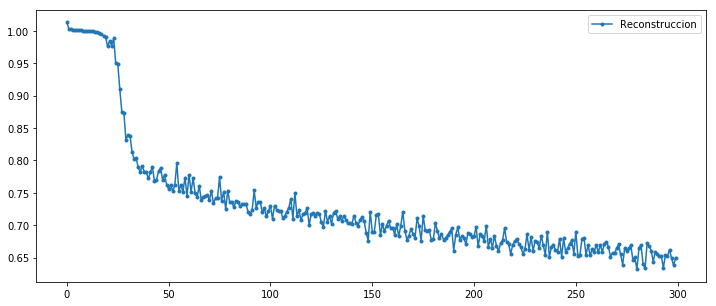

In [25]:
hist2 = vae.fit([X_train_t,X_train_s], X_train_s, epochs=EPOCHS, batch_size=BATCH_s)

plt.figure(figsize=(12,5))
plt.plot(hist2.history["MSE_loss"], '.-', label="Reconstruccion")
plt.legend()
plt.show()

Epoch 1/300
8634/8634 [==============================] - 31s 4ms/step - loss: 1.0068 - KL: 0.3434 - MSE_loss: 1.0064
Epoch 2/300
8634/8634 [==============================] - 26s 3ms/step - loss: 1.0026 - KL: 0.2439 - MSE_loss: 1.0023
Epoch 3/300
8634/8634 [==============================] - 27s 3ms/step - loss: 1.0023 - KL: 0.3761 - MSE_loss: 1.0019
Epoch 4/300
8634/8634 [==============================] - 26s 3ms/step - loss: 1.0018 - KL: 0.4909 - MSE_loss: 1.0013
Epoch 5/300
8634/8634 [==============================] - 26s 3ms/step - loss: 1.0015 - KL: 0.6029 - MSE_loss: 1.0009
Epoch 6/300
8634/8634 [==============================] - 26s 3ms/step - loss: 1.0013 - KL: 0.6931 - MSE_loss: 1.0006
Epoch 7/300
8634/8634 [==============================] - 26s 3ms/step - loss: 1.0011 - KL: 0.7480 - MSE_loss: 1.0004
Epoch 8/300
8634/8634 [==============================] - 26s 3ms/step - loss: 1.0009 - KL: 0.8321 - MSE_loss: 1.0000
Epoch 9/300
8634/8634 [==============================] - 26s 3ms

8634/8634 [==============================] - 26s 3ms/step - loss: 0.7225 - KL: 15.0782 - MSE_loss: 0.7075
Epoch 139/300
8634/8634 [==============================] - 26s 3ms/step - loss: 0.7203 - KL: 14.8749 - MSE_loss: 0.7054
Epoch 140/300
8634/8634 [==============================] - 26s 3ms/step - loss: 0.7111 - KL: 15.2840 - MSE_loss: 0.6959
Epoch 141/300
8634/8634 [==============================] - 26s 3ms/step - loss: 0.7096 - KL: 15.2933 - MSE_loss: 0.6943
Epoch 142/300
8634/8634 [==============================] - 26s 3ms/step - loss: 0.7349 - KL: 15.2441 - MSE_loss: 0.7197
Epoch 143/300
8634/8634 [==============================] - 26s 3ms/step - loss: 0.7346 - KL: 14.5812 - MSE_loss: 0.7200
Epoch 144/300
8634/8634 [==============================] - 26s 3ms/step - loss: 0.7274 - KL: 14.5690 - MSE_loss: 0.7128
Epoch 145/300
8634/8634 [==============================] - 26s 3ms/step - loss: 0.7164 - KL: 15.1679 - MSE_loss: 0.7013
Epoch 146/300
8634/8634 [=============================

8634/8634 [==============================] - 26s 3ms/step - loss: 0.6826 - KL: 16.1528 - MSE_loss: 0.6665
Epoch 275/300
8634/8634 [==============================] - 26s 3ms/step - loss: 0.6699 - KL: 15.9892 - MSE_loss: 0.6539
Epoch 276/300
8634/8634 [==============================] - 27s 3ms/step - loss: 0.6519 - KL: 16.2169 - MSE_loss: 0.6357
Epoch 277/300
8634/8634 [==============================] - 26s 3ms/step - loss: 0.6778 - KL: 16.0950 - MSE_loss: 0.6617
Epoch 278/300
8634/8634 [==============================] - 26s 3ms/step - loss: 0.6638 - KL: 16.2562 - MSE_loss: 0.6475
Epoch 279/300
8634/8634 [==============================] - 26s 3ms/step - loss: 0.6888 - KL: 15.9889 - MSE_loss: 0.6729
Epoch 280/300
8634/8634 [==============================] - 26s 3ms/step - loss: 0.6964 - KL: 15.6547 - MSE_loss: 0.6807
Epoch 281/300
8634/8634 [==============================] - 26s 3ms/step - loss: 0.6802 - KL: 15.7988 - MSE_loss: 0.6644
Epoch 282/300
8634/8634 [=============================

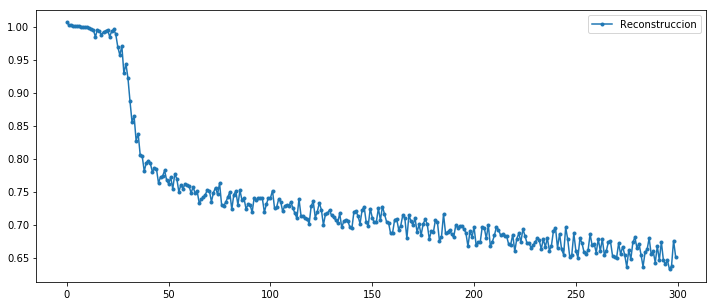

In [34]:
hist2 = vae.fit([X_train_t,X_train_s], X_train_s, epochs=EPOCHS, batch_size=BATCH_s)

plt.figure(figsize=(12,5))
plt.plot(hist2.history["MSE_loss"], '.-', label="Reconstruccion")
plt.legend()
plt.show()## 16

In [35]:
vae.get_layer("encoder").save_weights("./models/VAE_%dT_%dD_%de_E.h5"%(T,latent_dim,EPOCHS))
vae.get_layer("generator").save_weights("./models/VAE_%dT_%dD_%de_D.h5"%(T,latent_dim,EPOCHS))

### VAE escala

In [11]:
##### INPUTS ENCODER ######
x_lc = Input(shape = (T, channels) , name="LC_inp")
x_t = Input(shape = (T, 1) , name ="T_inp")
s_lc = Input(shape= (1,), name="scale_inp") #para pesar loss
x_lc_s = Lambda(Div_L, name="Divide")([x_lc, s_lc]) #NEW: quitar escala del dato (o escalar a una version normal)

##### CODIFY LIGHT CURVE ######
x = Concatenate(axis=-1)([x_t, x_lc_s]) 
f1 = Bidirectional(get_GRU(64, return_sequences=True))(x)
f1 = Bidirectional(get_GRU(64, return_sequences=False))(f1) 

##### CODIFY SCALE AND CONCATENATE ######
f1_s = Lambda(Norm_L, arguments={'mu':Slog_mu,'std':Slog_std}, name="norm")(s_lc) #mas capas?
f1_s = Dense(2, activation='tanh')(f1_s) #o tanh

f1 = Concatenate(axis=-1)([f1, f1_s]) #NEW: agregar escala a codificar

##### GET THE LATENT VARIABLE ######
z_mean = Dense(latent_dim,activation='linear')(f1)
z_log_var = Dense(latent_dim,activation='linear')(f1)
encoder = Model([x_t, x_lc, s_lc], [z_mean,z_log_var], name="encoder")
samp_model = define_samp_model(latent_dim) #model to sample


##### INPUTS DECODER ######
decoder_input = Input(shape=(latent_dim,))

##### RECONSTRCT SCALE ######
s_out = Dense(2, activation='tanh')(decoder_input)
s_out = Dense(1, activation='linear', name="reconsnorm")(s_out) #NEW: aprende s 
s_out = Lambda(RevertNorm_L, arguments={'mu':Slog_mu,'std':Slog_std},name="revertnorm")(s_out) #NEW: volver a escala normal 
s_hat = Model(decoder_input, s_out)(samp_model(encoder([x_t, x_lc, s_lc])))
S_model = Model([x_t, x_lc, s_lc], s_hat)

##### RECONSTRUCT LIGHT CURVE ######
decode = RepeatVector(T)(decoder_input)
decode = Concatenate(axis=-1)([x_t, decode]) #add time decode
decode = Bidirectional(get_GRU(64, return_sequences=True))(decode) #bidirectional
decode = Bidirectional(get_GRU(64, return_sequences=True))(decode) #bidirectional

decode = TimeDistributed(Dense(1, activation='linear'))(decode)
decode = Lambda(Mul_L, name="Multiply")([decode, s_out]) #NEW: recuperar escala de dato (multiplicar por std)
generator = Model([x_t, decoder_input], decode, name="generator")


##### VAE MODEL ######
out = generator([x_t, samp_model(encoder([x_t, x_lc, s_lc])) ])
vae = Model([x_t, x_lc, s_lc], out)

#define loss functions over model components
smse_LC = SMSE_loss(s_lc)
mse_S = MSLE_scale_loss(s_lc, s_hat) 
kl_loss = KL_loss(z_mean, z_log_var)


def Wvae_loss(y_true, y_pred):    
    return smse_LC(y_true, y_pred) + l*kl_loss(y_true, y_pred) +0.1*mse_S(y_true, y_pred)

vae.compile(optimizer='adam', loss=Wvae_loss, metrics = [smse_LC,kl_loss, mse_S])
vae.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
T_inp (InputLayer)              (None, 300, 1)       0                                            
__________________________________________________________________________________________________
LC_inp (InputLayer)             (None, 300, 1)       0                                            
__________________________________________________________________________________________________
scale_inp (InputLayer)          (None, 1)            0                                            
__________________________________________________________________________________________________
encoder (Model)                 [(None, 32), (None,  108996      T_inp[0][0]                      
                                                                 LC_inp[0][0]                     
          

Epoch 1/300
8634/8634 [==============================] - 32s 4ms/step - loss: 1.3339 - SMSE: 1.1229 - KL: 4.3992 - MSLE_scale: 2.0655
Epoch 2/300
8634/8634 [==============================] - 27s 3ms/step - loss: 1.1769 - SMSE: 1.0264 - KL: 7.4462 - MSLE_scale: 1.4307
Epoch 3/300
8634/8634 [==============================] - 27s 3ms/step - loss: 1.0971 - SMSE: 1.0099 - KL: 15.1932 - MSLE_scale: 0.7199
Epoch 4/300
8634/8634 [==============================] - 27s 3ms/step - loss: 1.0640 - SMSE: 1.0027 - KL: 18.4075 - MSLE_scale: 0.4292
Epoch 5/300
8634/8634 [==============================] - 27s 3ms/step - loss: 1.0584 - SMSE: 1.0026 - KL: 17.0121 - MSLE_scale: 0.3883
Epoch 6/300
8634/8634 [==============================] - 27s 3ms/step - loss: 1.0547 - SMSE: 1.0023 - KL: 15.8079 - MSLE_scale: 0.3657
Epoch 7/300
8634/8634 [==============================] - 27s 3ms/step - loss: 1.0520 - SMSE: 1.0024 - KL: 14.2777 - MSLE_scale: 0.3535
Epoch 8/300
8634/8634 [==============================] - 

8634/8634 [==============================] - 27s 3ms/step - loss: 0.7910 - SMSE: 0.7704 - KL: 17.3775 - MSLE_scale: 0.0324
Epoch 62/300
8634/8634 [==============================] - 26s 3ms/step - loss: 0.7804 - SMSE: 0.7595 - KL: 17.5008 - MSLE_scale: 0.0342
Epoch 63/300
8634/8634 [==============================] - 26s 3ms/step - loss: 0.7816 - SMSE: 0.7614 - KL: 16.9315 - MSLE_scale: 0.0330
Epoch 64/300
8634/8634 [==============================] - 26s 3ms/step - loss: 0.7824 - SMSE: 0.7623 - KL: 16.8489 - MSLE_scale: 0.0319
Epoch 65/300
8634/8634 [==============================] - 27s 3ms/step - loss: 0.7842 - SMSE: 0.7651 - KL: 15.9979 - MSLE_scale: 0.0310
Epoch 66/300
8634/8634 [==============================] - 27s 3ms/step - loss: 0.7751 - SMSE: 0.7560 - KL: 15.8888 - MSLE_scale: 0.0318
Epoch 67/300
8634/8634 [==============================] - 27s 3ms/step - loss: 0.7859 - SMSE: 0.7656 - KL: 17.0773 - MSLE_scale: 0.0319
Epoch 68/300
8634/8634 [==============================] - 27s

8634/8634 [==============================] - 26s 3ms/step - loss: 0.7166 - SMSE: 0.7024 - KL: 12.7859 - MSLE_scale: 0.0150
Epoch 181/300
8634/8634 [==============================] - 26s 3ms/step - loss: 0.7233 - SMSE: 0.7089 - KL: 13.0026 - MSLE_scale: 0.0133
Epoch 182/300
8634/8634 [==============================] - 26s 3ms/step - loss: 0.7272 - SMSE: 0.7131 - KL: 12.7659 - MSLE_scale: 0.0134
Epoch 183/300
8634/8634 [==============================] - 26s 3ms/step - loss: 0.7211 - SMSE: 0.7068 - KL: 12.9637 - MSLE_scale: 0.0136
Epoch 184/300
8634/8634 [==============================] - 26s 3ms/step - loss: 0.7335 - SMSE: 0.7195 - KL: 12.5711 - MSLE_scale: 0.0146
Epoch 185/300
8634/8634 [==============================] - 26s 3ms/step - loss: 0.7215 - SMSE: 0.7071 - KL: 12.8827 - MSLE_scale: 0.0143
Epoch 186/300
8634/8634 [==============================] - 26s 3ms/step - loss: 0.7096 - SMSE: 0.6951 - KL: 13.1305 - MSLE_scale: 0.0135
Epoch 187/300
8634/8634 [==============================

8634/8634 [==============================] - 27s 3ms/step - loss: 0.6711 - SMSE: 0.6531 - KL: 15.9619 - MSLE_scale: 0.0201
Epoch 299/300
8634/8634 [==============================] - 26s 3ms/step - loss: 0.6508 - SMSE: 0.6329 - KL: 16.2145 - MSLE_scale: 0.0163
Epoch 300/300
8634/8634 [==============================] - 26s 3ms/step - loss: 0.6777 - SMSE: 0.6595 - KL: 16.0526 - MSLE_scale: 0.0210


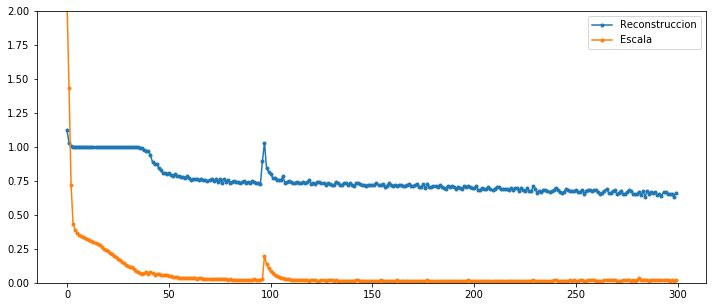

In [12]:
hist3 = vae.fit([X_train_t,X_train, S_train], X_train, epochs=EPOCHS, batch_size=BATCH_s)

plt.figure(figsize=(12,5))
plt.plot(hist3.history["SMSE"], '.-', label="Reconstruccion")
plt.plot(hist3.history["MSLE_scale"], '.-', label="Escala")
plt.legend()
plt.ylim(0,2)
plt.show()

Epoch 1/300
8634/8634 [==============================] - 34s 4ms/step - loss: 1.4497 - SMSE: 1.3050 - KL: 1.9724 - MSLE_scale: 1.4274
Epoch 2/300
8634/8634 [==============================] - 27s 3ms/step - loss: 1.1359 - SMSE: 1.0091 - KL: 0.8388 - MSLE_scale: 1.2601
Epoch 3/300
8634/8634 [==============================] - 27s 3ms/step - loss: 1.1219 - SMSE: 1.0100 - KL: 0.9954 - MSLE_scale: 1.1092
Epoch 4/300
8634/8634 [==============================] - 27s 3ms/step - loss: 1.0943 - SMSE: 1.0034 - KL: 7.1426 - MSLE_scale: 0.8379
Epoch 5/300
8634/8634 [==============================] - 27s 3ms/step - loss: 1.0789 - SMSE: 1.0026 - KL: 8.8782 - MSLE_scale: 0.6745
Epoch 6/300
8634/8634 [==============================] - 27s 3ms/step - loss: 1.0687 - SMSE: 1.0023 - KL: 7.7224 - MSLE_scale: 0.5876
Epoch 7/300
8634/8634 [==============================] - 26s 3ms/step - loss: 1.0641 - SMSE: 1.0021 - KL: 7.6582 - MSLE_scale: 0.5439
Epoch 8/300
8634/8634 [==============================] - 26s 3

8634/8634 [==============================] - 26s 3ms/step - loss: 0.7282 - SMSE: 0.7099 - KL: 16.7580 - MSLE_scale: 0.0158
Epoch 122/300
8634/8634 [==============================] - 26s 3ms/step - loss: 0.7293 - SMSE: 0.7106 - KL: 16.7713 - MSLE_scale: 0.0190
Epoch 123/300
8634/8634 [==============================] - 26s 3ms/step - loss: 0.7382 - SMSE: 0.7201 - KL: 16.5100 - MSLE_scale: 0.0163
Epoch 124/300
8634/8634 [==============================] - 26s 3ms/step - loss: 0.7328 - SMSE: 0.7145 - KL: 16.6452 - MSLE_scale: 0.0162
Epoch 125/300
8634/8634 [==============================] - 26s 3ms/step - loss: 0.7434 - SMSE: 0.7253 - KL: 16.1856 - MSLE_scale: 0.0190
Epoch 126/300
8634/8634 [==============================] - 26s 3ms/step - loss: 0.7405 - SMSE: 0.7226 - KL: 16.4239 - MSLE_scale: 0.0153
Epoch 127/300
8634/8634 [==============================] - 26s 3ms/step - loss: 0.7466 - SMSE: 0.7283 - KL: 16.2369 - MSLE_scale: 0.0201
Epoch 128/300
8634/8634 [==============================

8634/8634 [==============================] - 26s 3ms/step - loss: 0.6907 - SMSE: 0.6717 - KL: 17.4613 - MSLE_scale: 0.0158
Epoch 240/300
8634/8634 [==============================] - 26s 3ms/step - loss: 0.6683 - SMSE: 0.6491 - KL: 17.6554 - MSLE_scale: 0.0157
Epoch 241/300
8634/8634 [==============================] - 26s 3ms/step - loss: 0.6842 - SMSE: 0.6649 - KL: 17.7864 - MSLE_scale: 0.0149
Epoch 242/300
8634/8634 [==============================] - 26s 3ms/step - loss: 0.6777 - SMSE: 0.6584 - KL: 17.7968 - MSLE_scale: 0.0149
Epoch 243/300
8634/8634 [==============================] - 26s 3ms/step - loss: 0.6760 - SMSE: 0.6565 - KL: 17.9816 - MSLE_scale: 0.0146
Epoch 244/300
8634/8634 [==============================] - 26s 3ms/step - loss: 0.6788 - SMSE: 0.6594 - KL: 17.6167 - MSLE_scale: 0.0179
Epoch 245/300
8634/8634 [==============================] - 26s 3ms/step - loss: 0.7075 - SMSE: 0.6878 - KL: 17.5522 - MSLE_scale: 0.0212
Epoch 246/300
8634/8634 [==============================

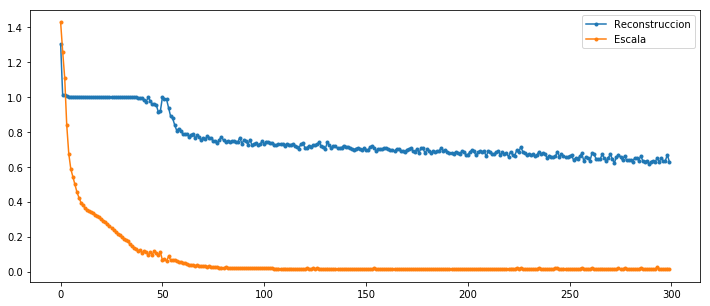

In [37]:
hist3 = vae.fit([X_train_t,X_train, S_train], X_train, epochs=EPOCHS, batch_size=BATCH_s)

plt.figure(figsize=(12,5))
plt.plot(hist3.history["SMSE"], '.-', label="Reconstruccion")
plt.plot(hist3.history["MSLE_scale"], '.-', label="Escala")
plt.legend()
plt.show() ## 16

In [13]:
vae.get_layer("encoder").save_weights("./models/VAE_S_%dT_%dD_%de_E.h5"%(T,latent_dim,EPOCHS))
vae.get_layer("generator").save_weights("./models/VAE_S_%dT_%dD_%de_D.h5"%(T,latent_dim,EPOCHS))

### Train comparison

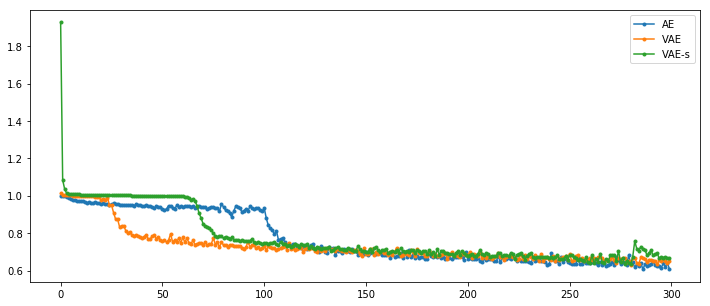

In [28]:
plt.figure(figsize=(12,5))
plt.plot(hist1.history["loss"], '.-', label="AE")
plt.plot(hist2.history["MSE_loss"], '.-', label="VAE")
plt.plot(hist3.history["SMSE"], '.-', label="VAE-s")
plt.legend()
plt.show()

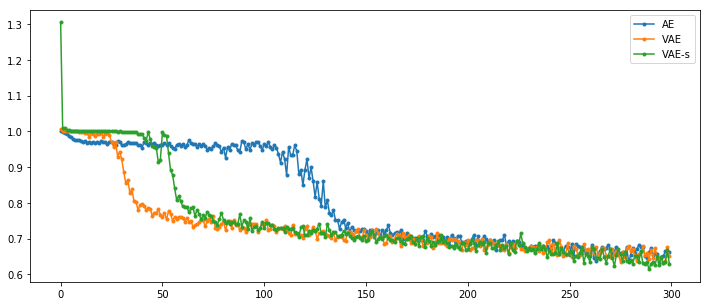

In [39]:
plt.figure(figsize=(12,5))
plt.plot(hist1.history["loss"], '.-', label="AE")
plt.plot(hist2.history["MSE_loss"], '.-', label="VAE")
plt.plot(hist3.history["SMSE"], '.-', label="VAE-s")
plt.legend()
plt.show() ##16

# Actualizar features tambn (Z)